In [1]:
import os
import numpy as np
import pickle
import gym
import pandas as pd
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
stable_baselines3.__version__ # printing out stable_baselines version used

C:\Users\wanha\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.7.0'

In [2]:
from stable_baselines3.common.evaluation import evaluate_policy

import optuna
import gym

def sample_dqn_params(trial:optuna.Trial):
  gamma = trial.suggest_categorical("gamma", [0.99, 0.95, 0.85, 0.5])
  exploration_fraction = trial.suggest_categorical("exploration_fraction", [0.01, 0.1, 0.5])
  learning_rate = trial.suggest_categorical("learning_rate", [1e-7, 5e-2, 1e-4, 1e-5, 5e-3, 1e-6])
  batch_size = trial.suggest_categorical("batch_size", [32, 128, 256])
  buffer_size = trial.suggest_categorical("buffer_size", [500, 2500, 50000])


  return {"gamma": gamma,
          "exploration_fraction": exploration_fraction,
          "learning_rate": learning_rate,
          "batch_size": batch_size,
          "buffer_size": buffer_size}

In [3]:
def objective(trial:optuna.Trial):
    
  hyperparameters = sample_dqn_params(trial)
  top_name = 'cost239'
  k_path = 10
      
  topology_dir = '/topologies/demo/' +  top_name +f'_{k_path}.h5'
  with open(f'..{topology_dir}', 'rb') as f:
      topology = pickle.load(f)

  node_request_probabilities = np.array([1/11, 1/11, 1/11, 1/11,
                                        1/11, 1/11, 1/11, 1/11,
                                        1/11, 1/11, 1/11])

  env_args = dict(topology=topology, seed=10, 
                  allow_rejection=False, # the agent cannot proactively reject a request
                  j=1, # consider only the first suitable spectrum block for the spectrum assignment
                  mean_service_holding_time=20, # value is not set as in the paper to achieve comparable reward values
                  episode_length=50, node_request_probabilities=node_request_probabilities, num_spectrum_resources = 358)

  # Create log dir
  log_dir = "./tmp_optimize/"
  os.makedirs(log_dir, exist_ok=True)

  env = gym.make('DeepRMSA-v0', **env_args)

  policy_kwargs = dict(net_arch=4*[128]) 

  model = DQN('MlpPolicy', env, verbose=0, policy_kwargs=policy_kwargs, **hyperparameters)
  model.learn(total_timesteps=50000)

  testing_env = gym.make('DeepRMSA-v0', **env_args)

  # Logs will be saved in log_dir/monitor.csv
  testing_env = Monitor(testing_env, log_dir + 'testing', info_keywords=('episode_service_blocking_rate','bit_rate_blocking_rate','failure', 'episode_failure',
                      'failure_slots','episode_failure_slots', 
                      'failure_disjointness','episode_failure_disjointness'))

  mean_reward, _ = evaluate_policy(model, testing_env, n_eval_episodes=1000)

  return mean_reward

log_dir = "./tmp_optimize/"
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler = sampler, pruner = optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials = 50, catch=(ValueError, ZeroDivisionError))

[I 2023-03-09 01:20:39,380] A new study created in memory with name: no-name-7cd82a84-6e7c-4e5c-a67b-16525866391b
[I 2023-03-09 01:31:58,194] Trial 0 finished with value: 17.135 and parameters: {'gamma': 0.95, 'exploration_fraction': 0.01, 'learning_rate': 0.005, 'batch_size': 32, 'buffer_size': 2500}. Best is trial 0 with value: 17.135.
[I 2023-03-09 01:42:52,360] Trial 1 finished with value: -5.584 and parameters: {'gamma': 0.95, 'exploration_fraction': 0.5, 'learning_rate': 0.005, 'batch_size': 256, 'buffer_size': 500}. Best is trial 0 with value: 17.135.
[I 2023-03-09 01:54:23,872] Trial 2 finished with value: 44.112 and parameters: {'gamma': 0.99, 'exploration_fraction': 0.1, 'learning_rate': 1e-06, 'batch_size': 128, 'buffer_size': 2500}. Best is trial 2 with value: 44.112.
[I 2023-03-09 02:05:37,912] Trial 3 finished with value: 14.854 and parameters: {'gamma': 0.5, 'exploration_fraction': 0.1, 'learning_rate': 1e-06, 'batch_size': 32, 'buffer_size': 500}. Best is trial 2 with v

C:\Users\wanha\AppData\Local\Temp\ipykernel_16672\22884200.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2023-03-09 10:19:05,564] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


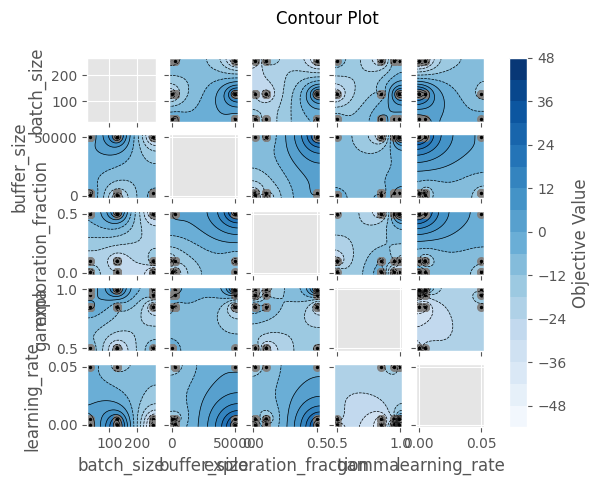

In [4]:
optuna.visualization.matplotlib.plot_contour(study)
plt.savefig(log_dir + f'OPTUNA_plot_contour.png', bbox_inches='tight')

C:\Users\wanha\AppData\Local\Temp\ipykernel_16672\2676523050.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf(study)


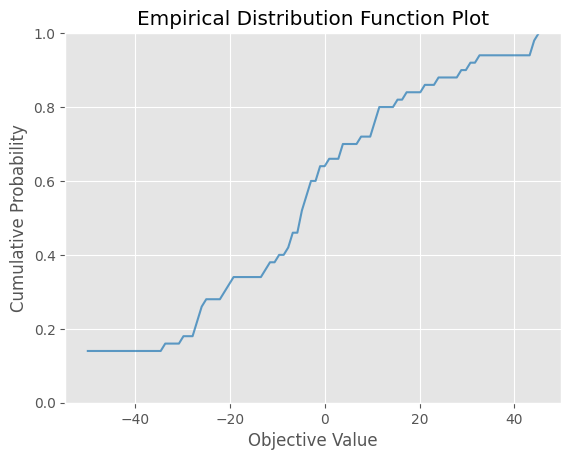

In [5]:
optuna.visualization.matplotlib.plot_edf(study)
plt.savefig(log_dir + f'OPTUNA_plot_edf.png', bbox_inches='tight')

C:\Users\wanha\AppData\Local\Temp\ipykernel_16672\1819793198.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_intermediate_values(study)
[W 2023-03-09 10:19:11,580] You need to set up the pruning feature to utilize `plot_intermediate_values()`


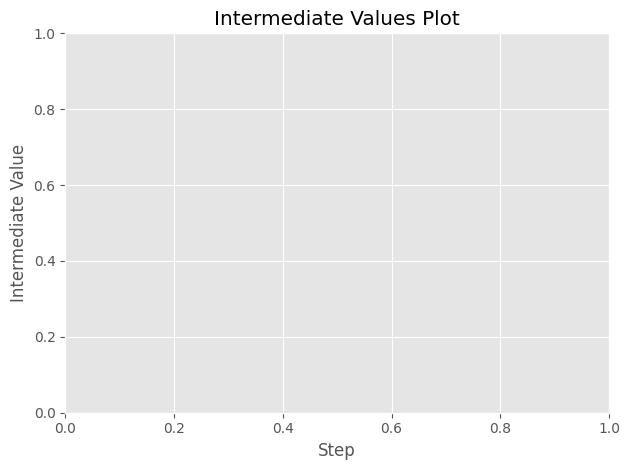

In [6]:
optuna.visualization.matplotlib.plot_intermediate_values(study)
plt.savefig(log_dir + f'OPTUNA_plot_intermediate_values.png', bbox_inches='tight')

C:\Users\wanha\AppData\Local\Temp\ipykernel_16672\3382956316.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


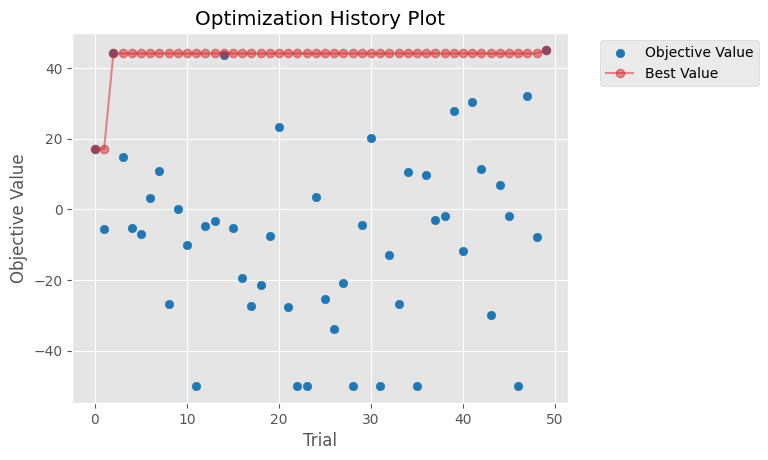

In [7]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig(log_dir + f'OPTUNA_plot_optimization_history.png', bbox_inches='tight')

C:\Users\wanha\AppData\Local\Temp\ipykernel_16672\3517291913.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


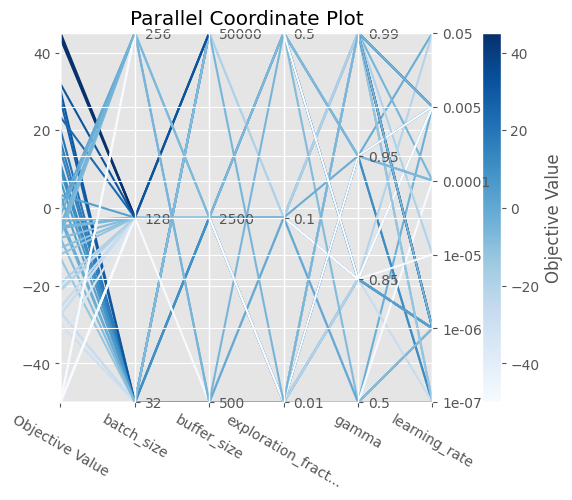

In [8]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.savefig(log_dir + f'OPTUNA_plot_parallel_coordinate.png', bbox_inches='tight')

C:\Users\wanha\AppData\Local\Temp\ipykernel_16672\3574195250.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


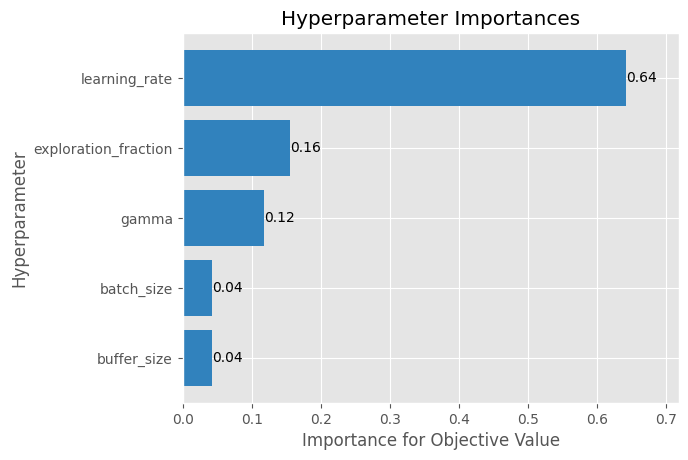

In [9]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig(log_dir + f'OPTUNA_plot_param_importances.png', bbox_inches='tight')

C:\Users\wanha\AppData\Local\Temp\ipykernel_16672\1358091771.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


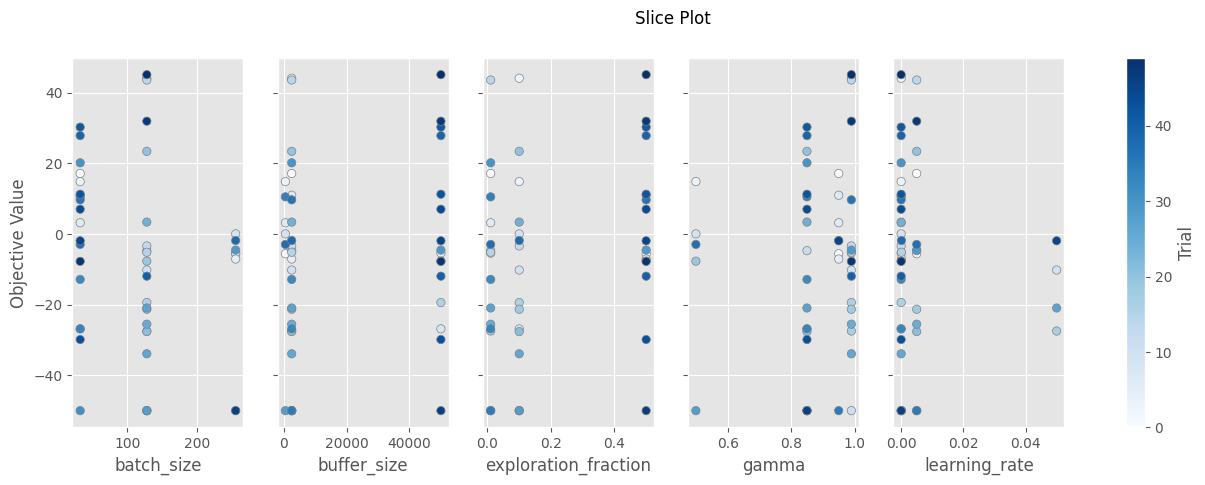

In [10]:
optuna.visualization.matplotlib.plot_slice(study)
plt.savefig(log_dir + f'OPTUNA_plot_slice', bbox_inches='tight')